# Assignment 3: Generative Modeling with [VQ-VAE](https://arxiv.org/pdf/1711.00937.pdf) and autoregressive priors

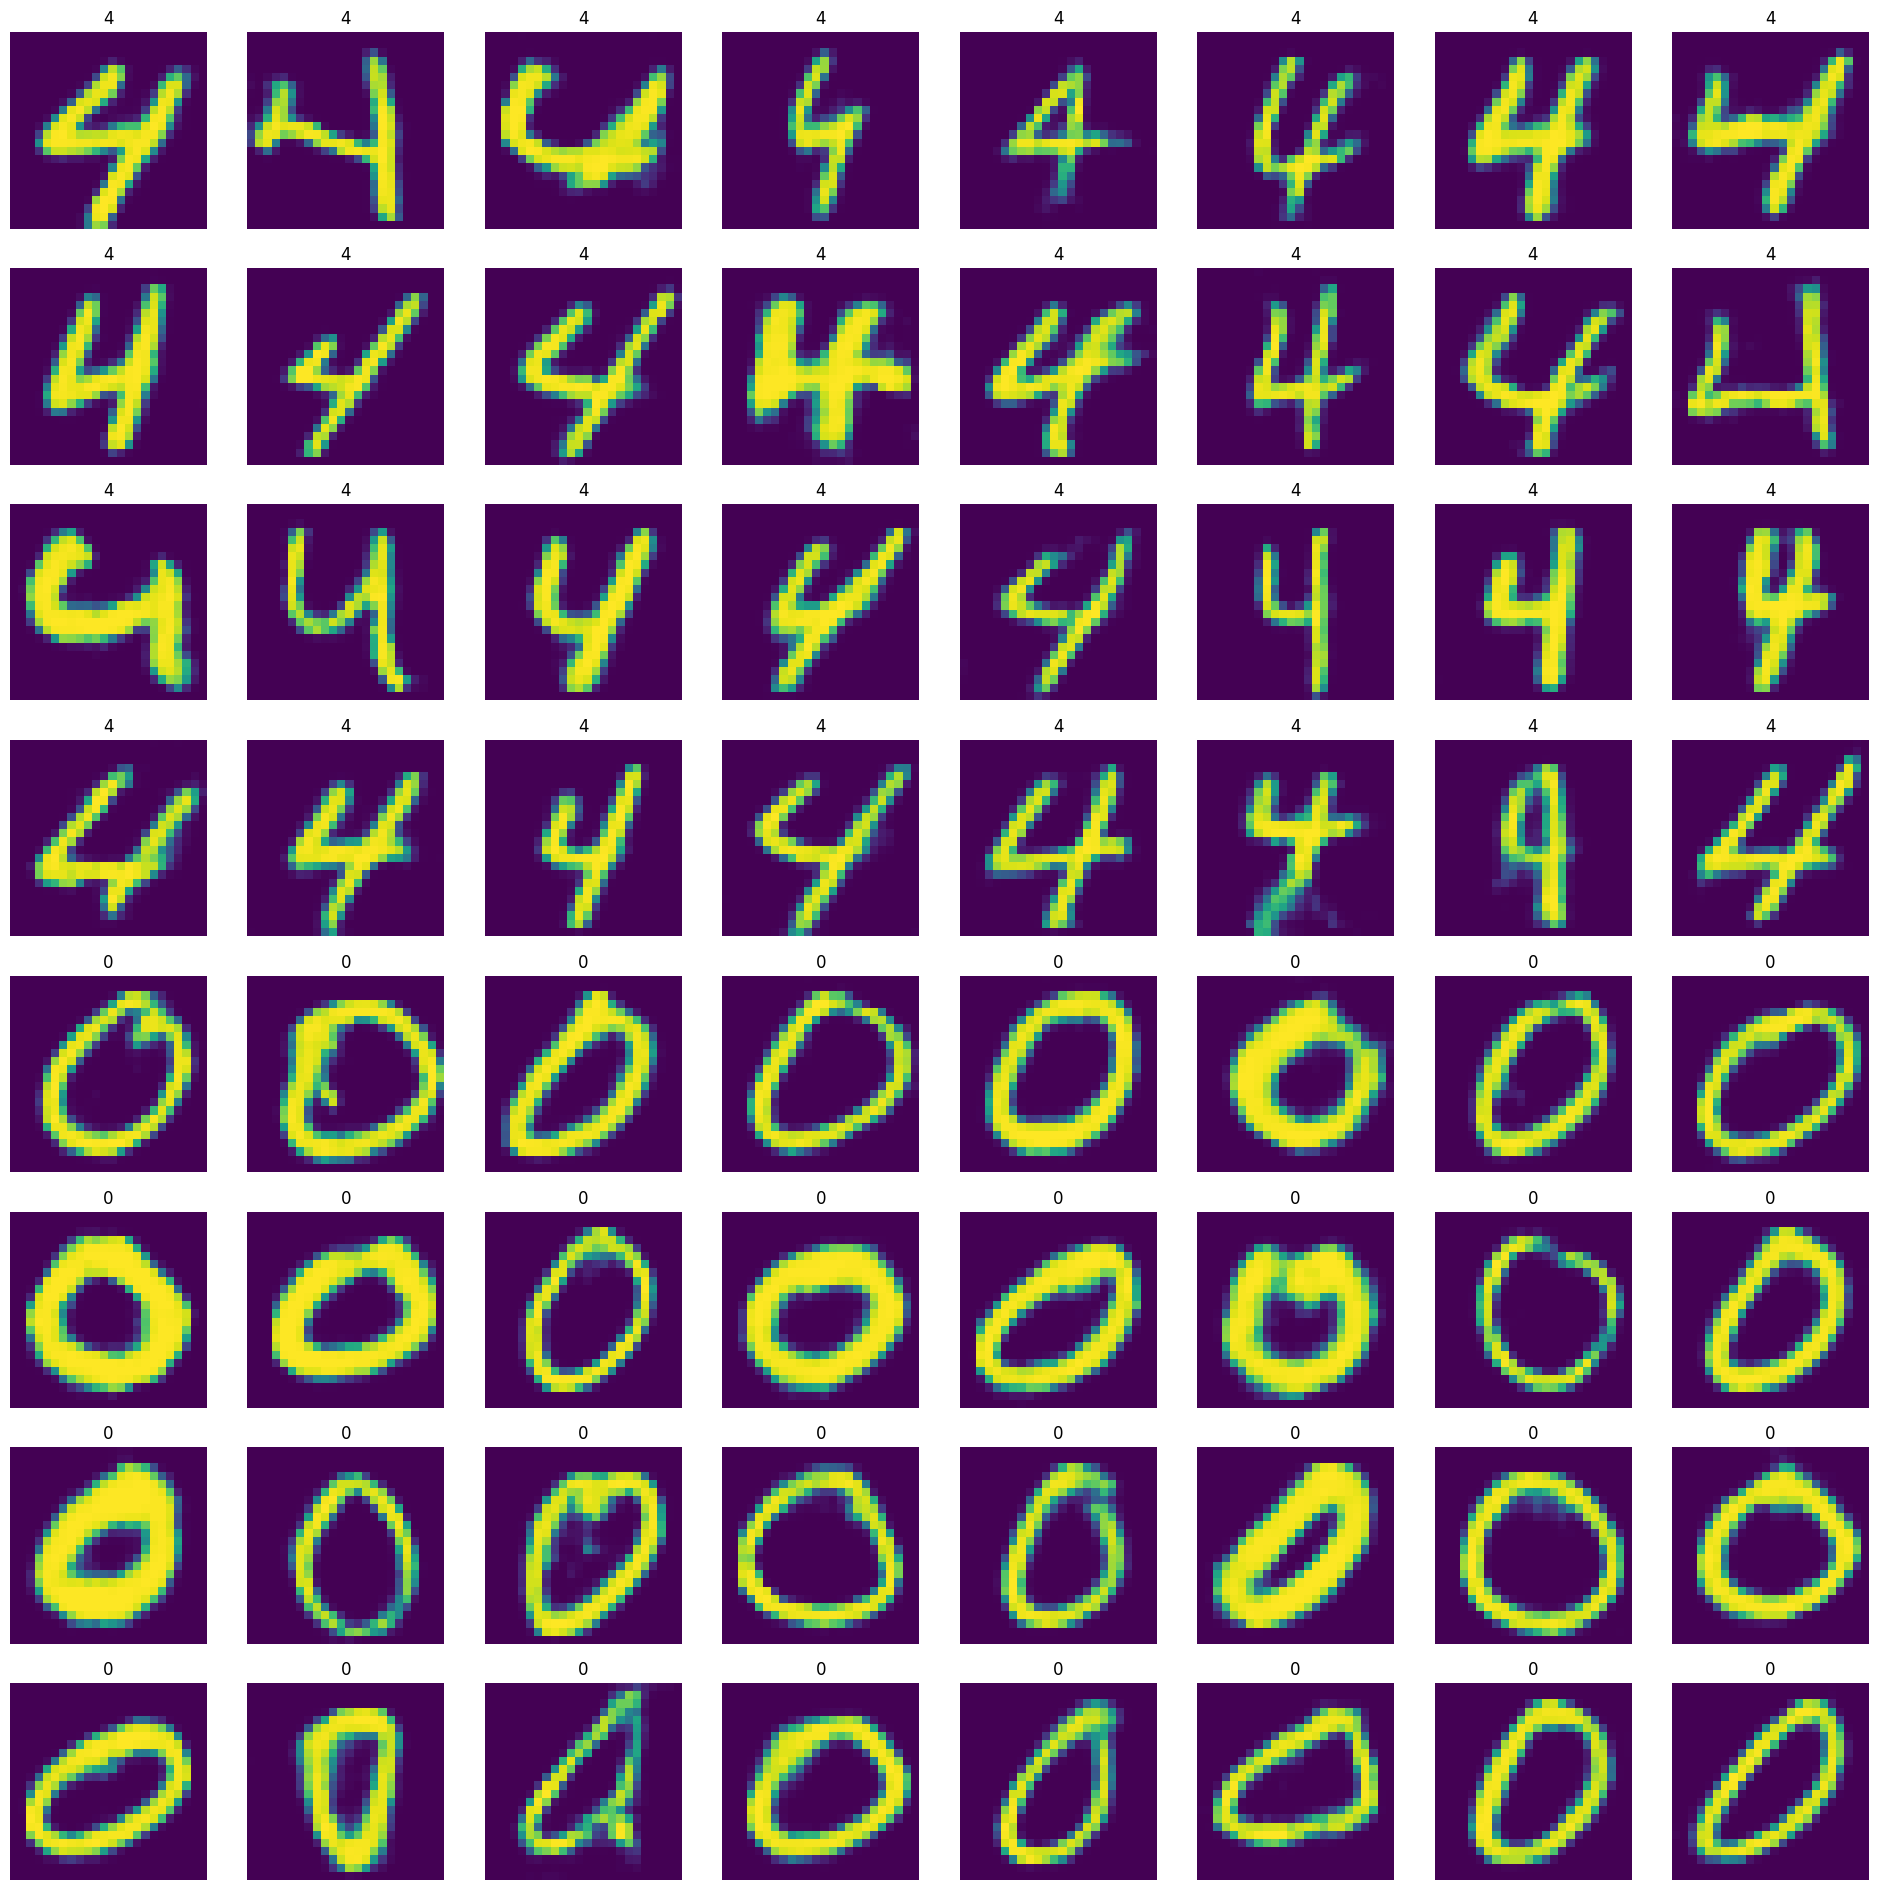

In this task you will:

- implement a [VQ-VAE](https://arxiv.org/pdf/1711.00937.pdf) module (4 pts),
- train it on the MNIST dataset (1pt),
- analyze its dictionary (1pt) and latent space (1pts),
- use it to generate new data (3 pts).

First, let us carefully read the [original paper](https://arxiv.org/pdf/1711.00937.pdf) to understand the general idea. Please - be sure that you understand the general overview of the model (Subsection 3.1) and how its loss function is implemented (Subsection 3.2).

## Data overview

We will use a subset of MNIST dataset. Instead of all digits we will only use data for `FIRST_DIGIT` and `SECOND_DIGIT`. For this task, keep predefined `0` and `4`, but you can later check your solution for other digits.

We will additionally resize it to the shape of `(BATCH_SIZE, 1, 24, 24)` by cutting `CUT=2` pixels from each side of each image. Please notice that data is rescaled to `[-1, 1]` interval.

The following code provides:
- `train_x` and `val_x` - train set and validation set for training of your model (`MNIST` narrowed down to `FIRST_DIGIT` and `SECOND_DIGIT` classes),
- `train_y` and `val_y` - train labels and validation labels indicating if given example has `FIRST_DIGIT` class,
- appropriate training and validation dataloaders.

**CAUTION:** for the purpose of this exercise do not modify `FIRST_DIGIT` and `SECOND_DIGIT`. Fell free to modify datasets and dataloaders, eg. to include additional augmentations but its not necessary and will not affect the final grade.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

!pip install lightning


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

MNIST_SIZE = 28
CUT = 2

FIRST_DIGIT = 0
SECOND_DIGIT = 4

train_dataset = torchvision.datasets.MNIST(
    root=r'./mnist/',
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)

val_dataset = torchvision.datasets.MNIST(
    root=r'./mnist/',
    train=False,
    transform=transforms.ToTensor(),
    download=True,
)

full_train_x = 2 * (train_dataset.data.float() / 255. - 0.5)[:, :, CUT:-CUT][:, CUT:-CUT]
full_val_x = 2 * (val_dataset.data.float() / 255. - 0.5)[:, :, CUT:-CUT][:, CUT:-CUT]

full_train_y = train_dataset.targets
full_val_y = val_dataset.targets

selected_digits_bool_train = torch.logical_or(
    full_train_y == FIRST_DIGIT,
    full_train_y == SECOND_DIGIT
)
selected_digits_bool_val = torch.logical_or(
    full_val_y == FIRST_DIGIT,
    full_val_y == SECOND_DIGIT
)

train_x = full_train_x[selected_digits_bool_train].reshape(
    -1,
    1,
    MNIST_SIZE - 2 * CUT,
    MNIST_SIZE - 2 * CUT,
).to(DEVICE)
val_x = full_val_x[selected_digits_bool_val].reshape(
    -1,
    1,
    MNIST_SIZE - 2 * CUT,
    MNIST_SIZE - 2 * CUT,
).to(DEVICE)

train_y = full_train_y[selected_digits_bool_train] == FIRST_DIGIT
val_y = full_val_y[selected_digits_bool_val] == FIRST_DIGIT

train_dataloader = DataLoader(train_x, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_x, batch_size=BATCH_SIZE, shuffle=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 66.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyli

100%|██████████| 9912422/9912422 [00:00<00:00, 30962922.02it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1098308.09it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9127539.97it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2715297.71it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



## Model Implementation (4pts)

### Encoder Model

Below you may find the `Encoder` module. Its constructor accepts `latent_dim` - the size of a latent space, and outputs a feature map of size `(BATCH_SIZE, latent_dim, 3, 3)`.

In [2]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(False),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(False),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.Sequential(*[Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        return self._layers(x)


class Encoder(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens // 2,
                                 kernel_size=3,
                                 stride=2,
                                 padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens // 2,
                                 out_channels=num_hiddens // 2,
                                 kernel_size=3,
                                 stride=2,
                                 padding=1)

        self._conv_3 = nn.Conv2d(in_channels=num_hiddens // 2,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=2,
                                 padding=1)

        self._residual_stack = ResidualStack(
            in_channels=num_hiddens,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens,
        )

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = torch.nn.ReLU()(x)

        x = self._conv_2(x)
        x = F.relu(x, inplace=False)

        x = self._conv_3(x)
        x = F.relu(x, inplace=False)

        return self._residual_stack(x)

### Decoder Model

Below one may find a `Decoder` model. It accepts a feature map of shape `(BATCH_SIZE, embedding_dim, H, W)` and outputs a batch of reconstructed images. It also has a `tanh` activation as outputs are rescaled to `[-1, 1]` interval.

In [3]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._conv_trans_3 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=1,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x, inplace=False)

        x = self._conv_trans_2(x)
        x = F.relu(x, inplace=False)

        return F.tanh(self._conv_trans_3(x))

### VectorQuantizer Module (3pts)

In this part you will implement a `VectorQuantizer` module from the [VQ-VAE paper](https://arxiv.org/pdf/1711.00937.pdf). Its constructor should accept:

- `num_embeddings` - the size of your dictionary,
- `embedding_dim` - the size of your latent space,
- `beta` - the rate for the commitment loss.

Its `forward` function should accept an `input` tensor of shape `(BATCH_SIZE, embedding_dim, H, W)` and output at least 5 tensors:

- `quantized_latent` - a tensor of size `(BATCH_SIZE, embedding_dim, H, W)` where for each example `n` and spatial position `h, w`, `quantized_latent[n, :, h, w]` is a matched element from your dictionary for the embedding vector `input[n, :, h, w]`. This tensor will be later fed to your `Decoder` model,
- `q_loss` - a dictionary learning loss (a second term of the loss function defined in the equation (3) in the [original paper](https://arxiv.org/pdf/1711.00937.pdf)),
- `e_loss` - a commitment loss (a third term of the loss function defined in the equation (3) in the [original paper](https://arxiv.org/pdf/1711.00937.pdf)),
- `vq_loss = q_loss + beta * e_loss` - full `VectorQuantizer` loss,
- `matched_indices` - a tensor of shape `(BATCH_SIZE, H, W)` where `matched_indices[n, h, w]` stores the information about which dictionary element was matched to the `input[n, :, h, w]` embedding vector of the `n-th` image in your batch.

As matching performed by a `VectorQuantizer` is not differentiable - your model should implement a [straight-through](https://arxiv.org/abs/1308.3432) gradient estimator, that will pass the gradient of the loss from `quantized_latent` directly to the `input` tensor.

**Caution**: according to the Subsection 3.2 of the [original paper](https://arxiv.org/pdf/1711.00937.pdf) `quantized_latent` should not be modified using the training gradient from the `Decoder`. It is only trained by `q_loss` and `e_loss`. If your `quantized_latent` is modified by a gradient from your `Decoder` you will **lose 1pt**.


**Hint:** [here](https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#gumbel_softmax) you may find a really simple implementation of a *straight-through* estimator for a Gumbel Softmax.



In [4]:
class VectorQuantizer(nn.Module):
    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        beta: float = 0.25,
    ):
        super(VectorQuantizer, self).__init__()
        # TODO
        self._beta = beta
        self._embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, x):
        # TODO
        x = x.permute(0, 2, 3, 1)
        dist = torch.cdist(x, self._embedding.weight)
        matched_indices = dist.argmin(dim=-1)
        quantized_latent = self._embedding(matched_indices)
        q_loss = F.mse_loss(quantized_latent.detach(), x)
        e_loss = F.mse_loss(quantized_latent, x.detach())
        vq_loss = q_loss + self._beta * e_loss
        quantized_latent = x + (quantized_latent - x).detach()
        quantized_latent = quantized_latent.permute(0, 3, 1, 2)

        return quantized_latent, q_loss, e_loss, vq_loss, matched_indices

    def quantize_indices(self, indices):
        return torch.nn.functional.embedding(indices, self._embedding.weight).permute(0, 3, 1, 2)

### Final Model (1pt)

Implement a `VQ-VAE` model that will combine `Encoder`, `VectorQuantizer` and `Decoder` models. Its constructor should accept at least:

- `embedding_dim` - the size of a latent space of your model,
- `num_embeddings` - the size of a dictionary of your `VectorQuantizer`,
- `beta` - the rate of a commitment loss of your `VectorQuantizer`.

and instantiate appropriate `Encoder`, `VectorQuantizer` and `Decoder` modules.

Additionally you should implement:
- all methods required for training and validation of your model using `lightning` module, use `mse_loss` as a reconstruction loss of your auto-encoder. Reconstruction loss should be logged on both training and validation data.

- an `encode` method that given a batch of images, returns a `latent` tensor - an output of `Encoder` as well as `quantized_latent` and `matched_indices` tensors - result of application of a `VectorQuantizer` to the `latent` tensor,
- a `decode_indices` method that given a batch of latent indices, will assign them appropriate vectors using `VectorQuantizer` and feed them to the decoder returning `reconstructed_images` tensor.
- a `decode_vectors` method that given a batch of latent vectors, will quantize them using `VectorQuantizer` and feed them to the decoder returning `reconstructed_images` tensor. This method should additionally return `matched_indices` from the quantization procedure.

In [44]:
import lightning.pytorch as pl
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

class Model(pl.LightningModule):
    def __init__(
        self,
        num_embeddings,
        embedding_dim,
        beta,
        num_hiddens,
        num_residual_hiddens,
        in_channels,
        num_residual_layers,
        recon_loss_weight
    ):
        super(Model, self).__init__()
        self._encoder = Encoder(in_channels, embedding_dim, num_residual_layers, num_residual_hiddens)
        self._vq = VectorQuantizer(num_embeddings, embedding_dim, beta)
        self._decoder = Decoder(embedding_dim, num_hiddens, num_residual_layers, num_residual_hiddens)
        self._recon_loss_weight = recon_loss_weight

    def training_step(self, batch):
        x = batch
        latent = self._encoder(x)
        quantized_latent, _, _, vq_loss, _ = self._vq(latent)
        reconstructed_x = self._decoder(quantized_latent)
        reconstruction_loss = F.mse_loss(reconstructed_x, x)
        total_loss = self._recon_loss_weight * reconstruction_loss + vq_loss
        self.log('train_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('vq_loss', vq_loss, on_step=True,  on_epoch=True, prog_bar=True, logger=True)
        self.log('train_reconstruction_loss', reconstruction_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return total_loss

    def validation_step(self, batch):
        x = batch
        latent = self._encoder(x)
        quantized_latent, _, _, vq_loss, _ = self._vq(latent)
        reconstructed_x = self._decoder(quantized_latent)
        reconstruction_loss = F.mse_loss(reconstructed_x, x)
        total_loss = self._recon_loss_weight * reconstruction_loss + vq_loss
        self.log('val_loss', total_loss, on_step=True,  on_epoch=True, prog_bar=True, logger=True)
        self.log('vq_loss', vq_loss, on_step=True,  on_epoch=True, prog_bar=True, logger=True)
        self.log('val_reconstruction_loss', reconstruction_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return total_loss

    def encode(self, x):
        latent = self._encoder(x)
        quantized_latent, _, _, _, matched_indices = self._vq(latent)

        return latent, quantized_latent, matched_indices

    def decode_vectors(self, x):
        _, quantized_latent, matched_indices = self.encode(x)
        reconstructed_images = self._decoder(quantized_latent)

        return reconstructed_images, matched_indices

    def decode_indices(self, indices, batch_size):
        quantized_vectors = self._vq.quantize_indices(indices)
        reconstructed_images = self._decoder(quantized_vectors)

        return reconstructed_images

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-3)

        return optimizer

## Model Training (1pt)

Instantiate and train your model on the prepared subset of `MNIST` data. Training will be considered as succesful if you achieve `<0.07` reconstruction loss on the validation data.

**Hint:** `num_embeddings` from range `[32, 64]` should be enough for a succesful training. The authors of [original paper](https://arxiv.org/pdf/1711.00937.pdf) suggest to use `beta=0.25`.

In [45]:
# TODO
import logging
import sys

from pytorch_lightning.loggers import TensorBoardLogger

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
pl.utilities.rank_zero_only.rank_zero_info = logging.info
logger = TensorBoardLogger("tb_logs", name="vq-vae")

model = Model(num_embeddings=32, embedding_dim=32, beta=0.25, num_hiddens=192, num_residual_hiddens=64, in_channels=1, num_residual_layers=2, recon_loss_weight=5)
model = model.to(DEVICE)
trainer = pl.Trainer(max_epochs=200, logger=logger)
trainer.fit(model, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type            | Params
---------------------------------------------
0 | _encoder | Encoder         | 48.1 K
1 | _vq      | VectorQuantizer | 1.0 K 
2 | _decoder | Decoder         | 745 K 
---------------------------------------------
794 K     Trainable params
0         Non-trainable params
794 K     Total params
3.178     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type            | Params
---------------------------------------------
0 | _encoder | Encoder

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


## Dictionary Visualization (1pt)

Visualize a dictionary learnt by your model. In order to solve your task you shoud:

1. Reshape your dictionary tensor to shape `(num_embeddings, embedding_dim, 1, 1)` and decode it using your VQ-VAE model.
2. Visualize each reconstructed dictionary element on an image grid.

Does the dictionary elements make a visual sense?

**Note on grading**: You can get extra points if you compare the distribution of occurences of a given dictionary element between the `FIRST_DIGIT` and `SECOND_DIGIT` in your training data.

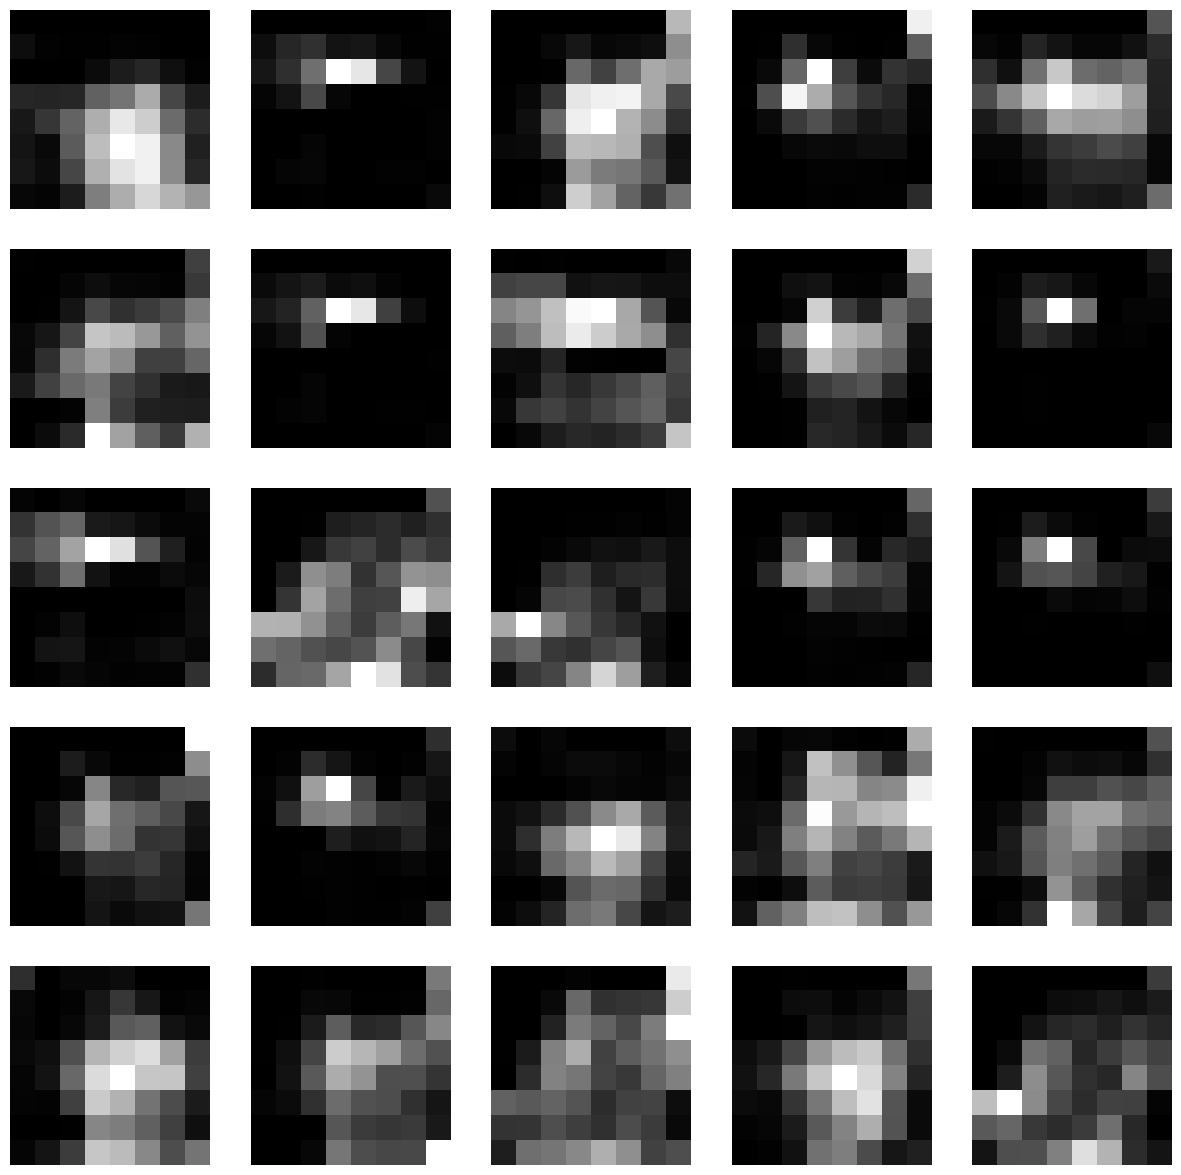

In [46]:
# TODO
import matplotlib.pyplot as plt
import numpy as np

def visualize_dictionary_elements(model, num_embeddings, embedding_dim):
    model.eval()

    with torch.no_grad():
        decoded_images = model._decoder(model._vq._embedding.weight.reshape(num_embeddings, -1, 1, 1))

        fig, axes = plt.subplots(figsize=(15, 15), nrows=int(np.sqrt(num_embeddings)), ncols=int(np.sqrt(num_embeddings)))
        for i, ax in enumerate(axes.flatten()):
            img = decoded_images[i].detach().cpu().numpy().squeeze()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        plt.show()

visualize_dictionary_elements(model, num_embeddings=32, embedding_dim=32)

In [47]:
def get_quantized_indices(model, data_loader, labels):
    model.eval()
    all_indices = []
    all_labels = []

    with torch.no_grad():
        for x, label in zip(data_loader, labels):
            x = x.to(model.device)
            _, _, indices = model.encode(x)
            all_indices.append(indices.cpu())
            all_labels.append(label.cpu())

    all_indices = torch.stack(all_indices[:-1]) # the last batch has a different shape
    all_labels = torch.stack(all_labels[:-1]) # the last batch has a different shape

    return all_indices, all_labels

In [48]:
def analyze_embedding_distribution(indices, labels, first_digit, second_digit):
    indices_first = indices[labels == first_digit].flatten()
    indices_second = indices[labels == second_digit].flatten()

    # adjusting, so we have a balanced sample
    num_of_samples = np.min([indices_first.shape[0], indices_second.shape[0]])
    indices_first, indices_second = indices_first[:num_of_samples], indices_second[:num_of_samples]

    num_embeddings = indices.max() + 1
    counts_first = torch.bincount(indices_first, minlength=num_embeddings)
    counts_second = torch.bincount(indices_second, minlength=num_embeddings)

    return counts_first, counts_second

In [49]:
def plot_distribution_comparison(counts_first, counts_second, first_digit, second_digit):
    x = np.arange(len(counts_first))

    plt.figure(figsize=(14, 6))
    plt.bar(x - 0.2, counts_first, width=0.4, label=f'Digit {first_digit}')
    plt.bar(x + 0.2, counts_second, width=0.4, label=f'Digit {second_digit}')
    plt.xlabel('Dictionary Element Index')
    plt.ylabel('Frequency of Occurrence')
    plt.title('Comparison of Dictionary Element Usage')
    plt.legend()
    plt.show()

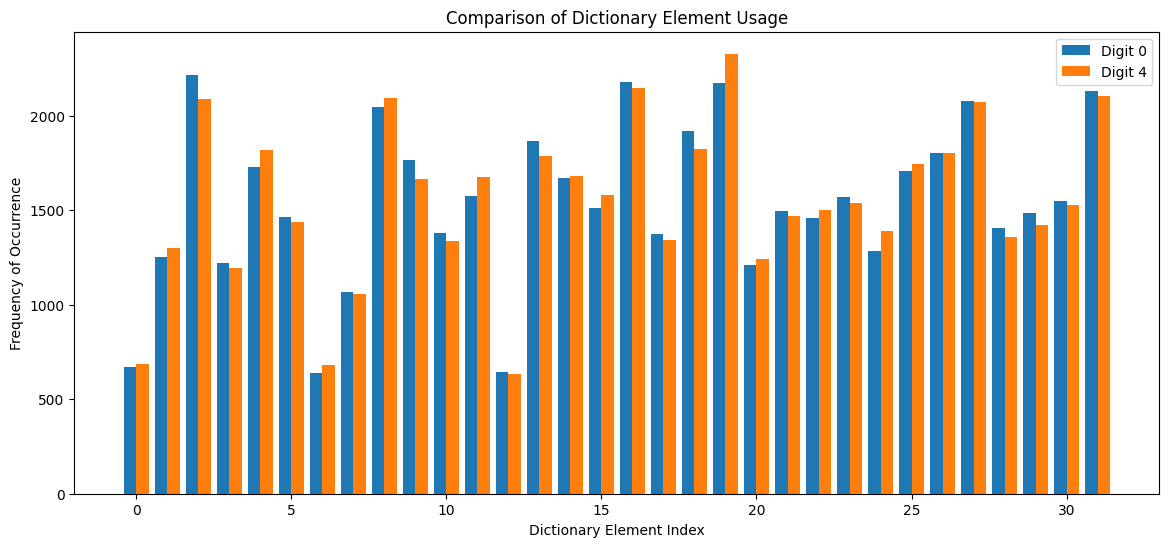

In [50]:
labels = full_train_y[selected_digits_bool_train]
indices, labels = get_quantized_indices(model, train_dataloader, labels)
counts_first, counts_second = analyze_embedding_distribution(indices, labels, FIRST_DIGIT, SECOND_DIGIT)
plot_distribution_comparison(counts_first, counts_second, FIRST_DIGIT, SECOND_DIGIT)

## Latent Space Visualization (1pt)

In this part you will visualize the latent space of your model. As it usually has more than 3-dimensions that are easy to visualize, we will use [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) dimensionality reduction in order to have a look at the most varying latent dimensions. To solve this subtask you should:

1. Encode `train_x` data to obtain its non-quantized `latent`,
2. Train a [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) model that explains `expected_explained_variance_ratio = 0.99` of `latent` variation. As latent is a 4-dimensional tensor - flatten it across spatial dimensions,
3. Draw 3 scatter plots - with the first and the second, the second and the third, and finally - the third and the fourth projections along principal components trained in the step 2. Visualize digits `FIRST_DIGIT` and `SECOND_DIGIT` with different colors. Use `alpha=0.3` in your visualization to get a sense of points density. Each axis should be named with an index of a principal component as well as its explained variance ratio.

Can you see any patterns? If not - is it good that your latent cannot discriminate between `FIRST_DIGIT` and `SECOND_DIGIT`? What fraction of all data dimensions is required to explain `expected_explained_variance_ratio` data comparing to the dimensionality?

In [51]:
# TODO
from sklearn.decomposition import PCA

def get_latent_space(model, data_loader):
    model.eval()
    latents = []

    with torch.no_grad():
        for batch in data_loader:
            latent, _, _ = model.encode(batch.to(DEVICE))
            latents.append(latent)
        latents = torch.cat(latents, dim=0)

    return latents


def train_pca(latents, expected_explained_variance_ratio=0.99):
    latents_flattened = latents.view(latents.size(0), -1).numpy()
    pca = PCA(n_components=expected_explained_variance_ratio)
    pca.fit(latents_flattened)

    return pca


def visualize_pca(pca, latents, labels, first_digit, second_digit):
    transformed = pca.transform(latents.view(latents.size(0), -1).numpy())

    digit_mask_1 = (labels == first_digit)
    digit_mask_2 = (labels == second_digit)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    pair_indices = [(0, 1), (1, 2), (2, 3)]
    for ax, (i, j) in zip(axes, pair_indices):
        ax.scatter(transformed[digit_mask_1, i], transformed[digit_mask_1, j], c='blue', alpha=0.3, label=f'Digit {first_digit}')
        ax.scatter(transformed[digit_mask_2, i], transformed[digit_mask_2, j], c='red', alpha=0.3, label=f'Digit {second_digit}')
        ax.set_xlabel(f'PC {i+1} ({pca.explained_variance_ratio_[i]:.2%})')
        ax.set_ylabel(f'PC {j+1} ({pca.explained_variance_ratio_[j]:.2%})')
        ax.legend()

    plt.show()

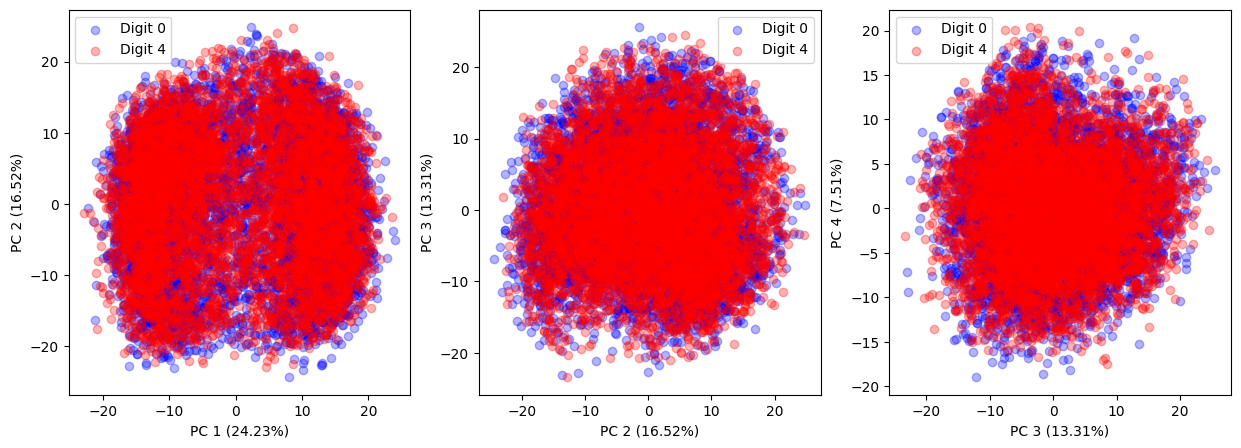

In [52]:
model.to(DEVICE)
latents = get_latent_space(model, train_dataloader).detach().cpu()
pca = train_pca(latents)
labels = full_train_y[selected_digits_bool_train].numpy()
visualize_pca(pca, latents, labels, FIRST_DIGIT, SECOND_DIGIT)

In [53]:
print(f"Dimensions needed to explain 99% of variance is {len(pca.explained_variance_ratio_)}")

Dimensions needed to explain 99% of variance is 22


## New Data Generation (3 pts)

In this part you will generate new data points using your VQ-VAE model. In order to solve this subtask you need to implement a conditional generative model that will generate new numbers. The model should accept a `target` batch of binary values and return a newly generated digits. A generated digit should resemble `0` if a provided value is `1`, and `4` if a provided value is `0` (this is accordingly to how `train_y` and `test_y` tensors were created).

A model should have an autoregressive architecture, that will generate a `(3, 3)` grid of latent indices, where each token is an integer number that represents the dictonary index from your VQ-VAE. This grid should be later passed through the dictionary of your `VectorQuantization` module, and sent to your decoder. It should be trained on the encoding indices of the training set. You will get 3 points for every model that is autoregressive and either spatial or sequential in nature (e.g., autoregressive transformer decoder, autogregressive LSTM, or Pixel-CNN) and at most 1 point for a non-autoregressive one.

**Note on grading**: You should generate 64 new images (32 for each digit type). In order to get 3 pts for this subtask, your images should:
- should make a visual sense,
- exhibit a significant variability (they should not be all the same),
- follow the condition that you set to your model.

Example of a grid of such images is presented at the top of this assignment.

(do not worry - this part will be graded gently :) ).

In [62]:
from torch.distributions import Categorical


class AutoregressivePrior(pl.LightningModule):
    def __init__(self, vq_vae_model, input_size, hidden_size, num_tokens):
        super(AutoregressivePrior, self).__init__()
        self._rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=True)
        self._fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 4),
            nn.ReLU(),
            nn.Linear(hidden_size // 4, num_tokens)
        )
        self._word_embedding = nn.Embedding(num_tokens, input_size)
        self._vq_vae_model = vq_vae_model

    def forward(self, x, hidden=None):
        x = self._word_embedding(x)
        output, hidden = self._rnn(x, hidden)
        output = self._fc(output)

        return output, hidden

    def training_step(self, batch):
        x, y = batch
        logits, _ = self.forward(x)
        logits = logits[:, 1:, :]
        logits = logits.reshape(-1, logits.size(-1))
        loss = F.cross_entropy(logits, y.view(-1))
        self.log('train_loss', loss, on_step=True,  on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch):
        x, y = batch
        logits, _ = self.forward(x)
        logits = logits[:, 1:, :]
        logits = logits.reshape(-1, logits.size(-1))
        loss = F.cross_entropy(logits, y.view(-1))
        self.log('val_loss', loss, on_step=True,  on_epoch=True, prog_bar=True, logger=True)

        return loss

    def sample_digits(self, target, num_samples=64):
        self.eval()
        samples = torch.zeros(num_samples, 10).long().to(self.device)
        samples[:, 0] = target
        for i in range(1, 10):
            logits, _ = self.forward(samples[:, :i + 1])
            logits = logits[:, :, :32]
            probs = torch.softmax(logits[:, i], dim=1)
            distribution = Categorical(probs)
            samples[:, i] = distribution.sample()

        samples = samples[:, 1:].view(num_samples, 3, 3)
        generated_images = self.decode_samples(samples, num_samples)

        return generated_images

    def decode_samples(self, indices, batch_size):
        return self._vq_vae_model.decode_indices(indices, batch_size)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-5)

        return optimizer

In [69]:
import logging
import sys

from pytorch_lightning.loggers import TensorBoardLogger

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
pl.utilities.rank_zero_only.rank_zero_info = logging.info
logger = TensorBoardLogger("tb_logs", name="lstm")
num_embeddings = 32
model.to(DEVICE)

gen_train_dataloader = DataLoader(list(zip(train_x, train_y)), batch_size=BATCH_SIZE, shuffle=True)
gen_val_dataloader = DataLoader(list(zip(val_x, val_y)), batch_size=BATCH_SIZE, shuffle=False)

train_x_indices, val_x_indices = [], []
train_y_indices, val_y_indices = [], []
for batch in gen_train_dataloader:
    x, y = batch
    x, y = x.to(DEVICE), y.to(DEVICE)
    _, _, indices = model.encode(x)
    indices = indices.reshape(len(x), -1)
    for i in range(indices.shape[0]):
        class_cond_vector = torch.cat([torch.tensor([1 * y[i] + num_embeddings], device=DEVICE), indices[i]], dim=0)
        train_x_indices.append(class_cond_vector)
        train_y_indices.append(indices[i])

for batch in gen_val_dataloader:
    x, y = batch
    x, y = x.to(DEVICE), y.to(DEVICE)
    _, _, indices = model.encode(x)
    indices = indices.reshape(len(x), -1)
    for i in range(indices.shape[0]):
        class_cond_vector = torch.cat([torch.tensor([1 * y[i] + num_embeddings], device=DEVICE), indices[i]], dim=0)
        val_x_indices.append(class_cond_vector)
        val_y_indices.append(indices[i])

lstm_train_dataloader = DataLoader(list(zip(train_x_indices, train_y_indices)), batch_size=BATCH_SIZE, shuffle=True)
lstm_val_dataloader = DataLoader(list(zip(val_x_indices, val_y_indices)), batch_size=BATCH_SIZE, shuffle=False)

In [72]:
lstm_model = AutoregressivePrior(model, input_size=32, hidden_size=64, num_tokens=34)
lstm_model = lstm_model.to(DEVICE)
trainer = pl.Trainer(max_epochs=10, logger=logger)
trainer.fit(lstm_model, lstm_train_dataloader, lstm_val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory tb_logs/lstm/version_8/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name            | Type       | Params
-----------------------------------------------
0 | _rnn            | LSTM       | 58.4 K
1 | _fc             | Sequential | 1.6 K 
2 | _word_embedding | Embedding  | 1.1 K 
3 | _vq_vae_model   | Model      | 794 K 
-----------------------------------------------
855 K     Trainable params
0         Non-trainable params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


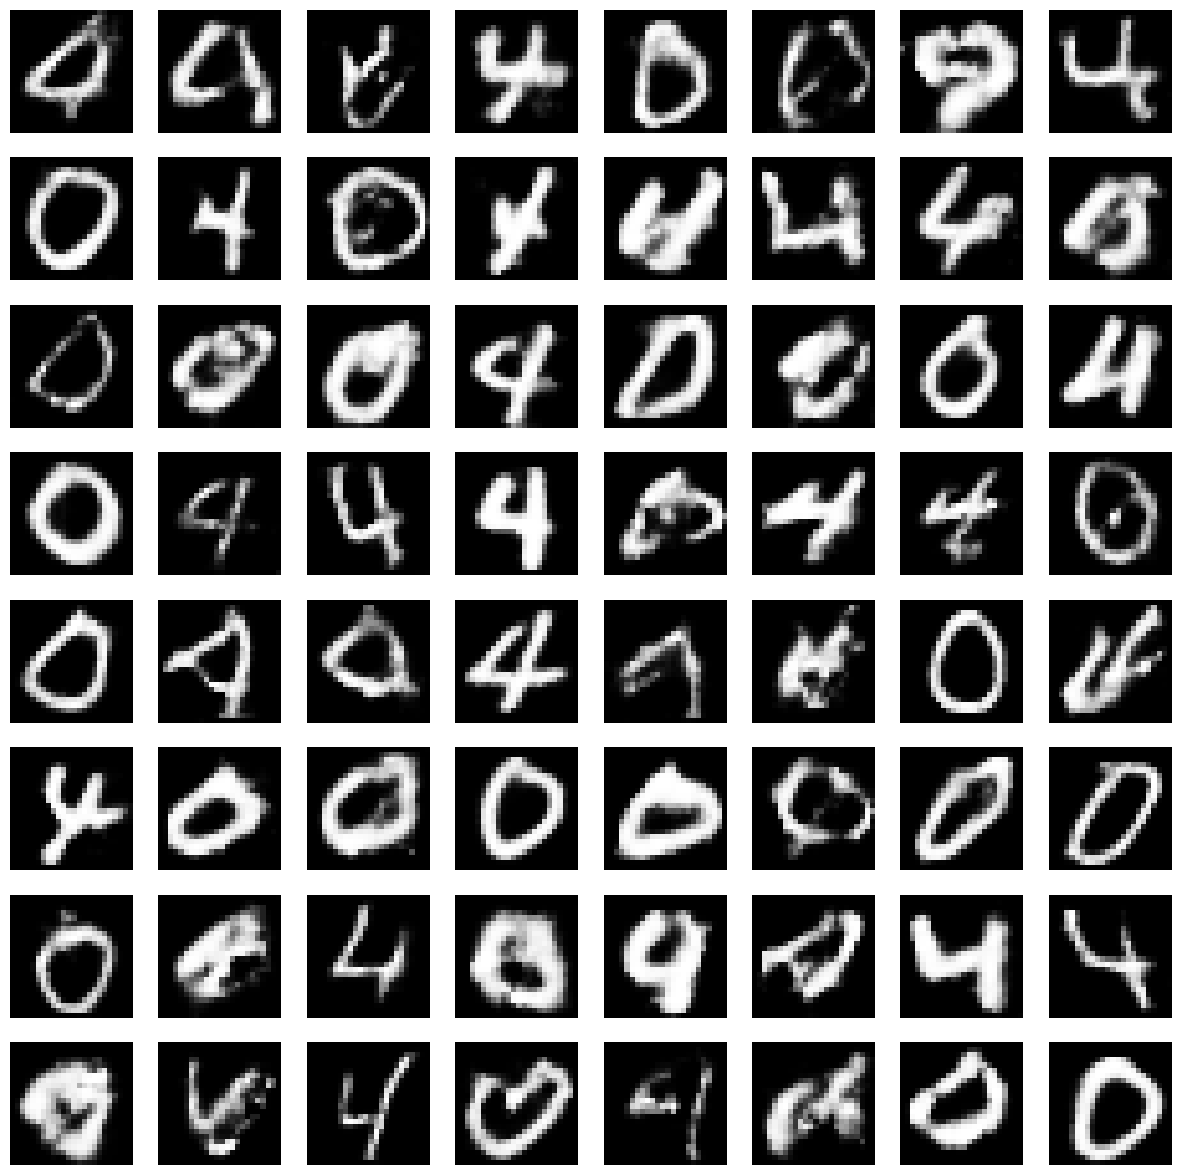

In [73]:
# plot digits generated using the lstm_model
target = torch.tensor(np.concatenate((np.zeros(32) + num_embeddings, (np.ones(32) + num_embeddings))))
generated_images = lstm_model.sample_digits(target=target.long())
fig, axes = plt.subplots(8, 8, figsize=(15, 15))
for i, ax in enumerate(axes.flatten()):
    img = generated_images[i].detach().cpu().numpy().squeeze()
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()